In [1]:
import pandas as pd
import math
import spacy
from spacy.matcher import Matcher

In [15]:
dataset = pd.read_csv("atis_intents.csv",header=None)

In [16]:
dataset

,0,1
0,atis_flight,i want to fly from boston at 838 am and arriv...
1,atis_flight,what flights are available from pittsburgh to...
2,atis_flight_time,what is the arrival time in san francisco for...
3,atis_airfare,cheapest airfare from tacoma to orlando
4,atis_airfare,round trip fares from pittsburgh to philadelp...
...,...,...
4973,atis_airfare,what is the airfare for flights from denver t...
4974,atis_flight,do you have any flights from denver to baltim...
4975,atis_airline,which airlines fly into and out of denver
4976,atis_flight,does continental fly from boston to san franc...


# First part

In [ ]:
!pip3 install -U spacy
!python3 -m spacy download en_core_web_md

In [18]:
nlp = spacy.load("en_core_web_md")
def data_preparation(data):
    data['obj'] = 0
    data['verb'] = 0
    for j in range(len(data)):
        doc = nlp(data[1][j])
        for token in doc:
            for token in doc:
                if token.dep_ == "dobj":
                    obj = token
                    verb = token.head
                    data['obj'][j] = token
                    data['verb'][j] = token.head
    label_freq = data.groupby(data[0], as_index=False).count()
    label_freq = label_freq.sort_values(by=[1], ascending=False).reset_index()

    return data[data['obj'] != 0]

In [ ]:
data_classes = data_preparation(dataset).reset_index()

In [20]:
dataset


,0,1,obj,verb
0,atis_flight,i want to fly from boston at 838 am and arriv...,0,0
1,atis_flight,what flights are available from pittsburgh to...,0,0
2,atis_flight_time,what is the arrival time in san francisco for...,washington,leaving
3,atis_airfare,cheapest airfare from tacoma to orlando,0,0
4,atis_airfare,round trip fares from pittsburgh to philadelp...,0,0
...,...,...,...,...
4973,atis_airfare,what is the airfare for flights from denver t...,0,0
4974,atis_flight,do you have any flights from denver to baltim...,flights,have
4975,atis_airline,which airlines fly into and out of denver,0,0
4976,atis_flight,does continental fly from boston to san franc...,0,0


In [9]:
def air_request(sentence, data_classes):

    def define_date(doc):
        matcher = Matcher(nlp.vocab)
        pattern = [{'ENT_TYPE': 'DATE'}]
        matcher.add('date', [pattern])
        matches = matcher(doc)
        dates = []
        for mid, start, end in matches:
            return (doc[start:end])

    def define_time(doc):
        matcher = Matcher(nlp.vocab)
        pattern = [{'ENT_TYPE': 'TIME'}]
        matcher.add('time', [pattern])
        matches = matcher(doc)
        timing = []
        for i in range(len(matches)):
            timing.append(doc[matches[i][1]+1])
        return timing

    def define_place(doc):
        nlp = spacy.load("en_core_web_sm")
        matcher = Matcher(nlp.vocab)
        pattern = [{"POS": "ADP"}, {"ENT_TYPE": "GPE"}]
        matcher.add("prepositionLocation", [pattern])
        matches = matcher(doc)
        places = []
        for i in range(len(matches)):
            places.append(doc[matches[i][1]+1])
        return places
        #for mid, start, end in matches:
        #    return (doc[start:end])

    def define_organisation(doc):
        matcher = Matcher(nlp.vocab)
        pattern = [{"ENT_TYPE": "ORG", "OP": "+"}]
        matcher.add("AirlineName", [pattern])
        matches = matcher(doc)
        organisations = []
        for i in range(len(matches)):
            organisations.append(doc[matches[i][1]+1])
        return organisations

    def define_abbreviation(doc):
        matcher = Matcher(nlp.vocab)
        pattern1 = [{"TEXT": {"REGEX": "\w{1,2}\d{1,2}"}}]
        pattern2 = [{"SHAPE": { "IN": ["x", "xx"]}}, {"SHAPE": {"IN": ["d", "dd"]}}]
        pattern3 = [{"TEXT": {"IN": ["class", "code", "abbrev", "abbreviation"]}}, {"SHAPE": { "IN": ["x", "xx"]}}]
        pattern4 =   [{"POS": "NOUN", "SHAPE": { "IN": ["x", "xx"]}}]
        matcher.add("abbrevEntities", [pattern1, pattern2, pattern3, pattern4])
        matches = matcher(doc)
        abbrev = []
        for mid, start, end in matches:
            abbrev.append(doc[start:end])
        return abbrev

    def define_intention(obj, verb, data_classes):
        average_similarity = []
        for i in range(0, len(data_classes)):
            average_similarity.append((obj.similarity(data_classes['obj'][i]) + verb.similarity(data_classes['verb'][i]))/2)
        _, idx = max((val, idx) for (idx, val) in enumerate(average_similarity))
        return data_classes[0][idx]

    def define_intention_else(doc, data_classes):
        all_similarity = []
        for i in range(0, len(data_classes)):
            all_similarity.append(doc.similarity(nlp(data_classes[0][i])))
        _, idx = max((val, idx) for (idx, val) in enumerate(all_similarity))
        return data_classes[0][idx]


    doc = nlp(sentence)
    for token in doc:
        if token.dep_ == "dobj":
            object_sent = token
            verb_sent = token.head
            if len(define_place(doc)) == 1 or define_date(doc) is None:
                return {'utterance' : sentence, 'intent ': define_intention(object_sent, verb_sent, data_classes),
                 'entities': {'date': define_date(doc), 'organizations' : define_organisation(doc),
                'abbreviation' : define_abbreviation(doc), 'locations': {
                  'from': define_place(doc)},
                    }
                   }
            else:
                return {'utterance' : sentence, 'intent ': define_intention(object_sent, verb_sent, data_classes),
                 'entities': {'date': define_date(doc), 'organizations' : define_organisation(doc),
                'abbreviation' : define_abbreviation(doc), 'locations': {
                  'from': define_place(doc)[0], 'to': define_place(doc)[1]},
                    }
                   }
        else:
            if len(define_place(doc)) == 1 or define_date(doc) is None:
                return {'utterance' : sentence, 'intent ': define_intention_else(doc, data_classes),
                 'entities': {'date': define_date(doc), 'organizations' : define_organisation(doc),
                'abbreviation' : define_abbreviation(doc), 'locations': {
                  'from': define_place(doc)},
                    }
                   }
            else:
                return {'utterance' : sentence, 'intent ': define_intention_else(doc, data_classes),
                 'entities': {'date': define_date(doc), 'organizations' : define_organisation(doc),
                'abbreviation' : define_abbreviation(doc), 'locations': {
                  'from': define_place(doc)[0], 'to': define_place(doc)[1]},
                    }
                   }

In [10]:
air_request("i need a flight after 6 pm on wednesday from oakland to salt lake city", data_classes)

<ipython-input-9-58a731c5b818>:68: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  all_similarity.append(doc.similarity(nlp(data_classes[0][i])))


{'utterance': 'i need a flight after 6 pm on wednesday from oakland to salt lake city',
 'intent ': 'atis_flight',
 'entities': {'date': wednesday,
  'organizations': [],
  'abbreviation': [pm],
  'locations': {'from': oakland, 'to': salt}}}

In [11]:
air_request("what is the earliest united airlines flight flying from denver", data_classes)

<ipython-input-9-58a731c5b818>:68: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  all_similarity.append(doc.similarity(nlp(data_classes[0][i])))


{'utterance': 'what is the earliest united airlines flight flying from denver',
 'intent ': 'atis_flight',
 'entities': {'date': None,
  'organizations': [],
  'abbreviation': [],
  'locations': {'from': [denver]}}}

In [12]:
air_request('what is booking class c', data_classes)

<ipython-input-9-58a731c5b818>:68: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  all_similarity.append(doc.similarity(nlp(data_classes[0][i])))


{'utterance': 'what is booking class c',
 'intent ': 'atis_flight',
 'entities': {'date': None,
  'organizations': [],
  'abbreviation': [class c, c],
  'locations': {'from': []}}}

# Machine Learning Techniques Part 2

# Data Preparation - Bag-of-words model

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [22]:
dataset

,0,1,obj,verb
0,atis_flight,i want to fly from boston at 838 am and arriv...,0,0
1,atis_flight,what flights are available from pittsburgh to...,0,0
2,atis_flight_time,what is the arrival time in san francisco for...,washington,leaving
3,atis_airfare,cheapest airfare from tacoma to orlando,0,0
4,atis_airfare,round trip fares from pittsburgh to philadelp...,0,0
...,...,...,...,...
4973,atis_airfare,what is the airfare for flights from denver t...,0,0
4974,atis_flight,do you have any flights from denver to baltim...,flights,have
4975,atis_airline,which airlines fly into and out of denver,0,0
4976,atis_flight,does continental fly from boston to san franc...,0,0


In [23]:
y, X = dataset[0], dataset[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
X_test

3992     i want to make a round trip flight from washi...
144      what are the coach fares from charlotte to la...
3062     now i need a flight from detroit to san diego...
4824                                     houston airports
2574     show me the cheapest one way fares from san d...
                              ...                        
4264     show me the cheapest flights from dallas to b...
2297                                   what airline is hp
256      show me flights from seattle to san francisco...
2135     what are the cheapest one way flights from de...
2389                     can i get a rental car in dallas
Name: 1, Length: 1494, dtype: object

In [25]:
y_test

3992            atis_flight
144            atis_airfare
3062            atis_flight
4824           atis_airport
2574           atis_airfare
               ...         
4264            atis_flight
2297           atis_airline
256             atis_flight
2135            atis_flight
2389    atis_ground_service
Name: 0, Length: 1494, dtype: object

# Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression()


In [27]:
accuracy_scores = []
for i in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]:
    vectorizer = CountVectorizer(ngram_range=i)
    vectorizer.fit(X_train)
    X_train_log = vectorizer.transform(X_train)
    X_test_log  = vectorizer.transform(X_test)
    classifier = LogisticRegression()
    classifier.fit(X_train_log, y_train)
    X_test_log = vectorizer.transform(X_test)
    score = classifier.score(X_test_log, y_test)
    accuracy_scores.append(score)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


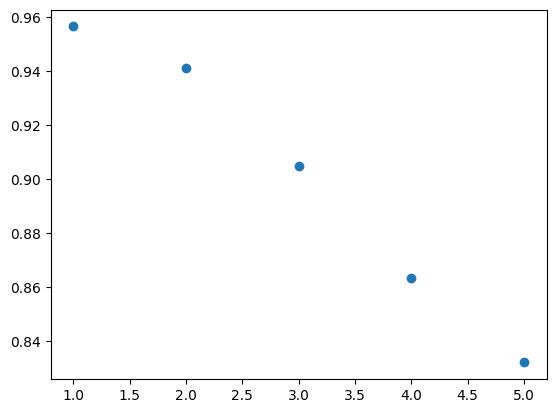

In [28]:
import matplotlib.pyplot as plt
x = [1, 2, 3, 4, 5]
plt.scatter(x, accuracy_scores)

# SVC

In [19]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear')

In [20]:
accuracy_scores = []
for i in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]:
    vectorizer = CountVectorizer(ngram_range=i)
    vectorizer.fit(X_train)
    X_train_log = vectorizer.transform(X_train)
    X_test_log  = vectorizer.transform(X_test)
    clf.fit(X_train_log, y_train)
    X_test_log = vectorizer.transform(X_test)
    score = clf.score(X_test_log, y_test)
    accuracy_scores.append(score)



In [21]:
print(accuracy_scores)

[0.9658634538152611, 0.9585006693440429, 0.9263721552878179, 0.8888888888888888, 0.8493975903614458]


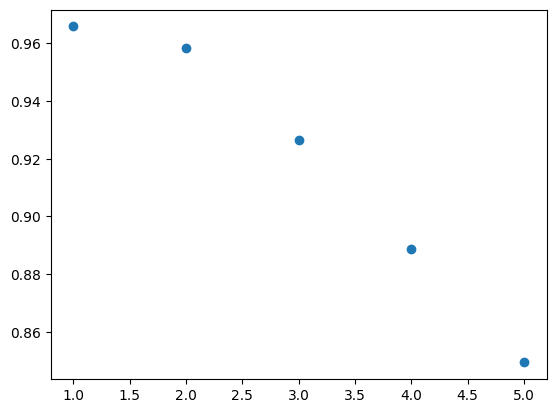

In [22]:
x = [1, 2, 3, 4, 5]
plt.scatter(x, accuracy_scores)

# XGBoost

In [23]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.ensemble import GradientBoostingClassifier

In [24]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
accuracy_scores = []
for i in [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]:
    vectorizer = CountVectorizer(ngram_range=i)
    vectorizer.fit(X_train)
    X_train_log = vectorizer.transform(X_train)
    X_test_log  = vectorizer.transform(X_test)
    clf.fit(X_train_log, y_train)
    X_test_log = vectorizer.transform(X_test)
    score = clf.score(X_test_log, y_test)
    accuracy_scores.append(score)

In [26]:
print(accuracy_scores)

[0.9551539491298527, 0.9457831325301205, 0.9082998661311914, 0.8761713520749665, 0.8366800535475234]


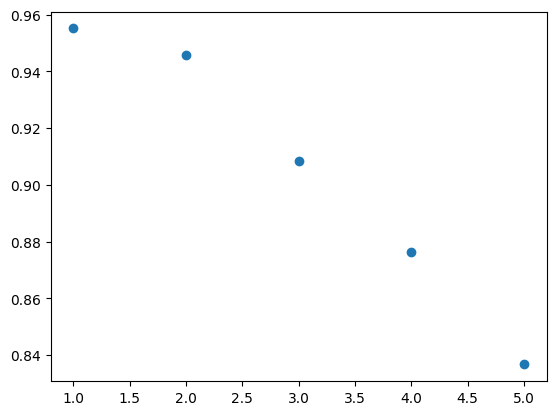

In [25]:
x = [1, 2, 3, 4, 5]
plt.scatter(x, accuracy_scores)

To sum up, the best model is SVC with the parameter ngram = 1. The score here is higher than in every model.